In [1]:
import cnn3
from cnn3 import CNN3
from cnn3 import nn
from cnn3 import trainloader, testloader
from cnn3 import torch, optim
from cnn3 import tqdm
from cnn3 import np

from cnn3 import num_class_c1, num_class_c2, num_class_c3
from cnn3 import labels_c_1,labels_c_2, labels_c_3

from telegramBot import Terminator

In [2]:
cnn3.torch.autograd.set_detect_anomaly(False);
cnn3.torch.autograd.profiler.emit_nvtx(False);
cnn3.torch.autograd.profiler.profile(False);

In [5]:
class HCNN3(nn.Module):
    
    def __init__(self, learning_rate, momentum, nesterov, trainloader, testloader, 
                 epochs, num_class_c1, num_class_c2, num_class_c3, labels_c_1, labels_c_2, labels_c_3, 
                 every_print = 512, switch_point = None, custom_training = False, training_size = 50000):

        super().__init__(learning_rate, momentum, nesterov, trainloader, testloader, 
                 epochs, num_class_c1, num_class_c2, num_class_c3, labels_c_1, labels_c_2, labels_c_3, 
                 every_print, switch_point, custom_training, training_size)

        self.layer1  = nn.Conv2d(3, 64, (3,3), padding = 'same', bias = False)
        self.layer2  = nn.BatchNorm2d(64)
        self.layer3  = nn.Conv2d(64, 64, (3,3), padding = 'same', bias = False)
        self.layer4  = nn.BatchNorm2d(64)
        self.layer5  = nn.MaxPool2d((2,2), stride = (2,2))

        self.layer6  = nn.Conv2d(64, 128, (3,3), padding = 'same', bias = False)
        self.layer7  = nn.BatchNorm2d(128)
        self.layer8  = nn.Conv2d(128, 128, (3,3), padding = 'same', bias = False)
        self.layer9  = nn.BatchNorm2d(128)
        self.layer10 = nn.MaxPool2d((2,2), stride = (2,2))

        self.layerb11 = nn.Linear(8*8*128, 256, bias = False)
        self.layerb12 = nn.BatchNorm1d(256)
        self.layerb13 = nn.Dropout(0.5)
        self.layerb14 = nn.Linear(256, 256, bias = False)
        self.layerb15 = nn.BatchNorm1d(256)
        self.layerb16 = nn.Dropout(0.5)
        self.layerb_mid = nn.Linear(256, 256)
        
        self.layerb17 = nn.Linear(256, 32)
        self.layerb18 = nn.Linear(32, self.num_c_1)
        
        self.layerb27 = nn.Linear(256, 32)
        self.layerb28 = nn.Linear(32, self.num_c_2)
        self.layerb28_ = nn.Linear(self.num_c_1, self.num_c_2)
        
        self.layerb37 = nn.Linear(256, 32)
        self.layerb38 = nn.Linear(32, self.num_c_3)
        self.layerb38_ = nn.Linear(self.num_c_2, self.num_c_3)


        self.optimizer = optim.SGD(self.parameters(), lr = self.learning_rate[0], 
                                   momentum = self.momentum, nesterov = self.nesterov)
        self.criterion = nn.CrossEntropyLoss()

    
    def forward(self, x):

        # block 1
        z = self.layer1(x)
        z = self.activation(z)
        z = self.layer2(z)
        z = self.layer3(z)
        z = self.activation(z)
        z = self.layer4(z)
        z = self.layer5(z)

        # block 2
        z = self.layer6(z)
        z = self.activation(z)
        z = self.layer7(z)
        z = self.layer8(z)
        z = self.activation(z)
        z = self.layer9(z)
        z = self.layer10(z)
        z = torch.flatten(z, start_dim = 1)

        # branch 1
        z = self.layerb11(z)
        z = self.activation(z)
        z = self.layerb12(z)
        z = self.layerb13(z)
        z = self.layerb14(z)
        z = self.activation(z)
        z = self.layerb15(z)
        z = self.layerb16(z)
        z = self.layerb_mid(z)
        z = self.activation(z)

        # projections
        ort2, ort3 = self.project(z)

        #vbranch 1
        b1 = self.layerb17(z)
        b1 = self.activation(b1)
        b1 = self.layerb18(b1)
        
        # branch 2
        b2 = self.layerb27(ort2)
        b2 = self.activation(b2)
        b2 = self.layerb28(b2) + self.layerb28_(b1.clone().detach())

        # branch 3
        b3 = self.layerb37(ort3)
        b3 = self.activation(b3)
        b3 = self.layerb38(b3) + self.layerb38_(b2.clone().detach())

        return b1, b2, b3

    def debug_forward(self, x):
        
        z = self.layerb_mid(x)
        z = self.activation(z)

        # projections
        ort2, ort3 = self.project(z)

        #vbranch 1
        b1 = self.layerb17(z)
        b1 = self.activation(b1)
        b1 = self.layerb18(b1)
        
        # branch 2
        b2 = self.layerb27(ort2)
        b2 = self.activation(b2)
        b2 = self.layerb28(b2) + self.layerb28_(b1.clone().detach())

        # branch 3
        b3 = self.layerb37(ort3)
        b3 = self.activation(b3)
        b3 = self.layerb38(b3) + self.layerb38_(b2.clone().detach())

        return b1, b2, b3

In [6]:
learning_rate = [3e-3, 5e-4, 1e-4]
momentum = 0.9
nesterov = True
epochs = 60
every_print = 64
switch_point = None

In [7]:
bot = Terminator()
cnn = HCNN3(learning_rate, momentum, nesterov, trainloader, testloader, 
                 epochs, num_class_c1, num_class_c2, num_class_c3, labels_c_1, labels_c_2, labels_c_3, every_print, switch_point)

Training: 100%|██████████████████████████████████| 9/9 [55:30<00:00, 370.10s/it]


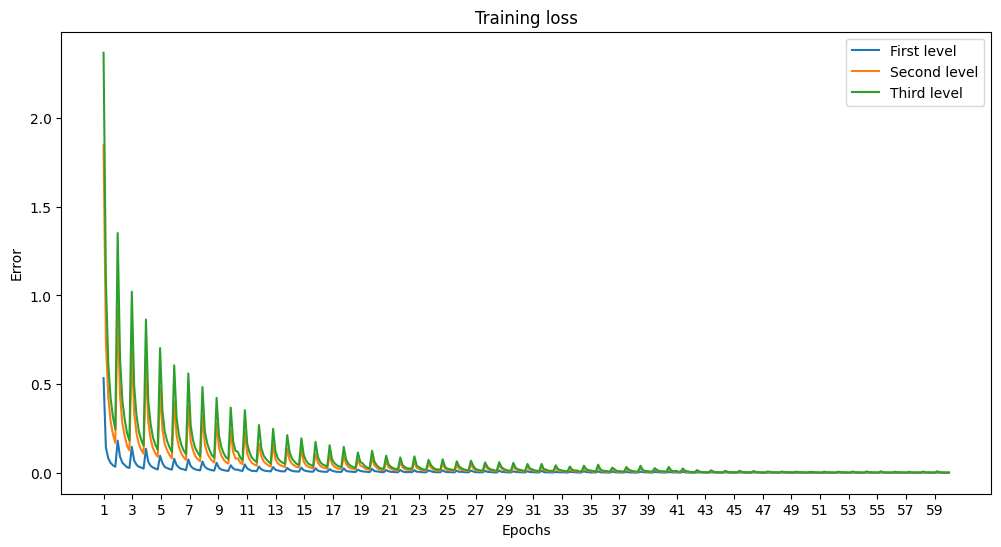

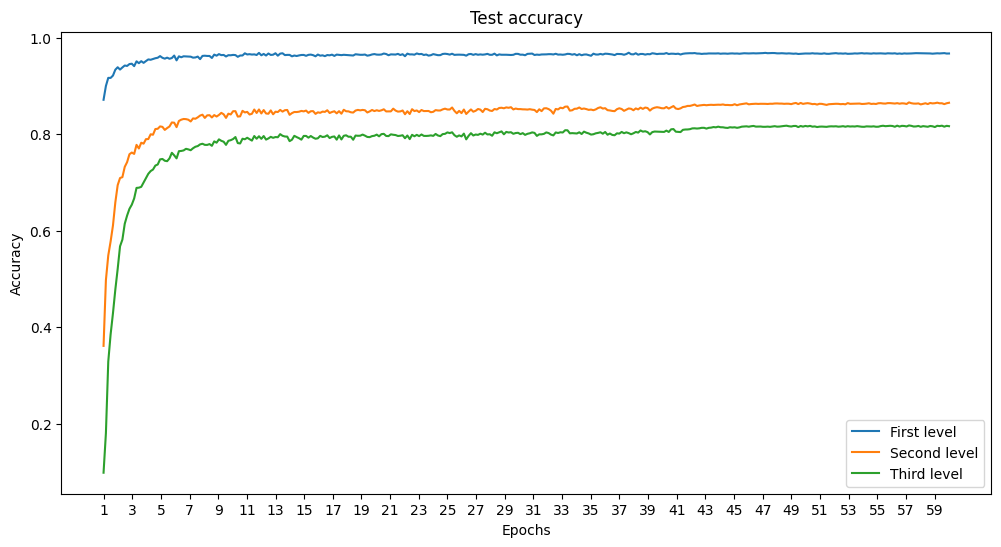

Accuracy for class transport: 95.93 %
Accuracy for class animal: 97.27 %

Accuracy for class sky  : 84.70 %
Accuracy for class water: 90.00 %
Accuracy for class road : 95.00 %
Accuracy for class bird : 72.80 %
Accuracy for class reptile: 86.00 %
Accuracy for class pet  : 84.75 %
Accuracy for class medium: 85.95 %

Accuracy for class plane: 84.50 %
Accuracy for class car  : 91.20 %
Accuracy for class bird : 73.00 %
Accuracy for class cat  : 65.30 %
Accuracy for class deer : 79.20 %
Accuracy for class dog  : 74.50 %
Accuracy for class frog : 86.10 %
Accuracy for class horse: 84.30 %
Accuracy for class ship : 90.00 %
Accuracy for class truck: 88.00 %

Accuracy on c1: 96.00 %
Accuracy on c2: 86.00 %
Accuracy on c3: 81.00 %

Cross-accuracy transport vs c2: 99.40 %
Cross-accuracy animal vs c2: 99.55 %

Cross-accuracy sky   vs c3: 99.30 %
Cross-accuracy water vs c3: 99.90 %
Cross-accuracy road  vs c3: 99.30 %
Cross-accuracy bird  vs c3: 99.59 %
Cross-accuracy reptile vs c3: 99.30 %
Cross-accu

In [8]:
#cnn.train_model(verbose = False)
err = False
#filename = "models/B-CNN3_CIFAR10_H_oca_c"
filename = "models/B-CNN3_CIFAR10_H_oca_c_dlr"

try:
    cnn.train_track(filename)
    cnn.save_model(filename)
    msg = cnn.test(mode = "write")
    cnn.write_configuration(filename)
    
except Exception as errore:
    err = errore

if err is False:
    bot.sendMessage("Programma terminato correttamente\n\n\nPerformance:\n\n"+msg)
else:
    bot.sendMessage("Programma NON terminato correttamente\nTipo di errore: "+err.__class__.__name__+"\nMessaggio: "+str(err))
    raise err

In [9]:
total_params = sum(p.numel() for p in cnn.parameters() if p.requires_grad)
total_params

2515448